# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
import IPython.display as display
import random
import pandas as pd
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import ModelCheckpoint
from random import choice, sample
from PIL import Image
import numpy as np
from tensorflow import keras

In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive

/content/drive/MyDrive


In [ ]:
%cd ML\ \&\ Climate

/content/drive/MyDrive/ML & Climate


In [ ]:
! ls

 best_model_checkpoint.hdf5		  test-jpg.tar
 best_resnet_model.hdf5			  test-jpg.tar.7z
 best_stratified_model.hdf5		  test-tif-v2.tar.7z
 cache.tf-data.data-00000-of-00001	  test_v2_file_mapping.csv.zip
 cache.tf-data.index			  train-jpg
'ML & Climate EDA.ipynb'		  train-jpg.tar
 test_cache.tf-data.data-00000-of-00001   train-tif-v2.tar.7z
 test_cache.tf-data.index		  train_v2.csv
 test-jpg				  train_v2.csv.zip


In [ ]:
ls train-jpg | parallel convert -colorspace sRGB train-jpg/{} fixed-train-jpg/{}

In [ ]:
#!tar -xvf 'train-jpg.tar'

# Training Set

In [ ]:
data_root = pathlib.Path("/content/drive/MyDrive/ML & Climate/train-jpg")

In [ ]:
all_img_paths = list(data_root.glob('*'))

In [ ]:
all_img_paths = [str(path) for path in all_img_paths]

In [ ]:
len(all_img_paths)

40479

In [ ]:
all_img_paths[:5]

['/content/drive/MyDrive/ML & Climate/train-jpg/train_9443.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9395.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9322.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9499.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9385.jpg']

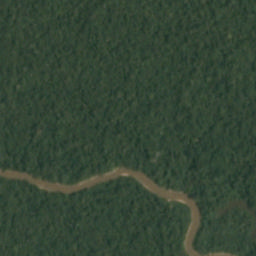

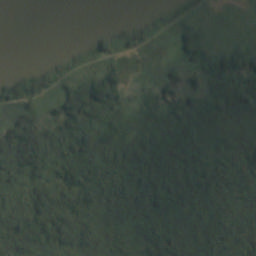

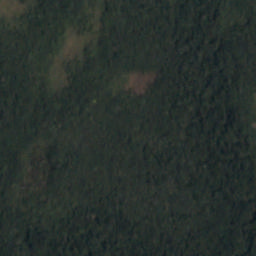

In [ ]:
for n in range(3):
  image_path = random.choice(all_img_paths)
  display.display(display.Image(image_path))

In [ ]:
# for testing on the different methods of training using a subset of the data
small_img_paths = sample(all_img_paths, 2000)

In [ ]:
len(small_img_paths)

2000

In [ ]:
# medium sized dataset for final training that takes a reasonable amount of time
med_img_paths = sample(all_img_paths, 8000)

In [ ]:
len(med_img_paths)

8000

# Test Set

In [ ]:
#!7z x 'test-jpg.tar.7z'

In [ ]:
#!tar -xvf  'test-jpg.tar'

In [ ]:
test_root = pathlib.Path("/content/drive/MyDrive/ML & Climate/test-jpg")

In [ ]:
test_img_paths = list(test_root.glob('*'))

In [ ]:
test_img_paths = [str(path) for path in test_img_paths]

In [ ]:
len(test_img_paths)

24038

In [ ]:
test_img_paths[:5]

['/content/drive/MyDrive/ML & Climate/test-jpg/test_8452.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8563.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8615.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8596.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8531.jpg']

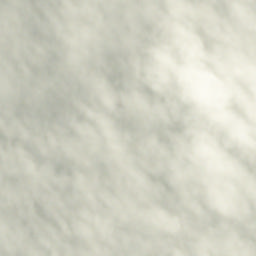

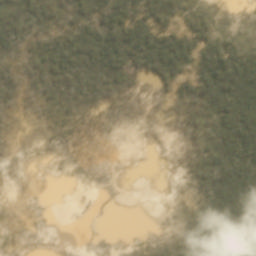

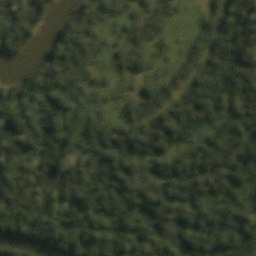

In [ ]:
for n in range(3):
  image_path = random.choice(all_img_paths)
  display.display(display.Image(image_path))

# Data Labels

In [ ]:
labels = pd.read_csv("train_v2.csv")

In [ ]:
labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


There is no labels for the test set, since this is a kaggle competition. Will have to split the training set in to train, val, and test.

Here are the label distributions:

In [ ]:
tags = defaultdict(lambda: 0)
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    tags[tag] += 1

In [ ]:
tags

defaultdict(<function __main__.<lambda>()>,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

In [ ]:
deforest_tags = {}
# these are the tags that we are considering as deforestation
deforestation = ['agriculture', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine',
                 'selective_logging', 'road', 'habitation']    
for tag, count in tags.items():
  if tag in deforestation:
    deforest_tags[tag] = count

In [ ]:
deforest_tags

{'agriculture': 12315,
 'habitation': 3660,
 'road': 8071,
 'cultivation': 4547,
 'slash_burn': 209,
 'conventional_mine': 100,
 'artisinal_mine': 339,
 'selective_logging': 340}

In [ ]:
deforestation_count = 0
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    if tag in deforest_tags:
      deforestation_count += 1
      break

In [ ]:
print("Total counts of deforestation: ", deforestation_count)
print("The percentage of deforestation labels: ", 
      deforestation_count/len(labels))

Total counts of deforestation:  15899
The percentage of deforestation labels:  0.39277156056226686


The dataset is somewhat balanced, with around 40% positive labels (deforestation) and 60% negative labels (no deforestation).

**Binary Data Labels**

First run, try to encode all training example into either has some classification of deforestation or not.

In [ ]:
pathlib.Path(all_img_paths[0]).name.split(".")[0]

'train_9443'

In [ ]:
bin_labels = {} # binary 0/1 labels for whether img has deforestation
i = 0
for each in labels["tags"]:
  tags = each.split(" ")
  for t in tags:
    if t in deforest_tags:
      # 1 for deforestation, 0 for no deforestation
      bin_labels[labels.loc[i]["image_name"]] = 1
      break
  if labels.loc[i]["image_name"] not in bin_labels:
    bin_labels[labels.loc[i]["image_name"]] = 0
  i += 1

In [ ]:
# an array of the binary labels to feed into train-test-split
all_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in all_img_paths]

In [ ]:
count = 0
for each in all_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(all_bin_labels)-count)

deforestation:  15899 
no deforestation:  24580


In [ ]:
# DELETE LATER
small_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in small_img_paths]
count = 0
for each in small_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(small_bin_labels)-count)
print("The percentage of deforestation labels: ", 
      count/len(small_bin_labels))

deforestation:  777 
no deforestation:  1223
The percentage of deforestation labels:  0.3885


In [ ]:
med_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in med_img_paths]
count = 0
for each in med_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(med_bin_labels)-count)
print("The percentage of deforestation labels: ", 
      count/len(med_bin_labels))

deforestation:  3139 
no deforestation:  4861
The percentage of deforestation labels:  0.392375


# Modeling

In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(all_img_paths, 
                                                                      all_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [ ]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(small_img_paths, 
                                                                      small_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [ ]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(med_img_paths, 
                                                                      med_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

Display a few images and their labels

1


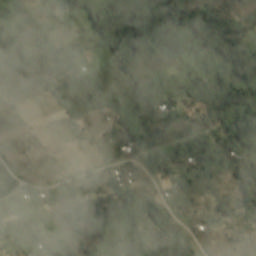


1


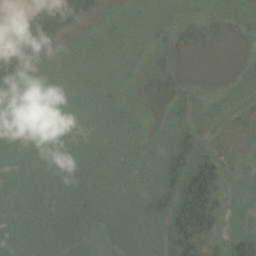


0


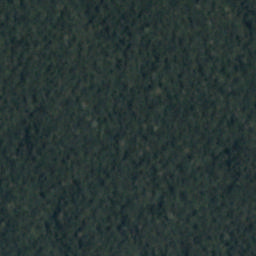

In [ ]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(train_labels[i])
  display.display(display.Image(image_path))
  print()

In [ ]:
# img_raw = tf.io.read_file(train_paths[0])
# print(repr(img_raw)[:100]+"...")

In [ ]:
# img_tensor = tf.image.decode_image(img_raw, channels=3, dtype=tf.dtypes.float32)
# print(img_tensor.shape)
# print(img_tensor.dtype)

In [ ]:
# Test to see the image dimensions
img_raw = Image.open(train_paths[0]).convert("RGB")
img = img = np.asarray(img_raw) /255

In [ ]:
print(img.shape)
print(img.min(), img.max())

(256, 256, 3)
0.09803921568627451 0.403921568627451


**Parameters for loader**

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SIZE = 1000
BUFFER_SIZE = 1000

In [ ]:
# def load_and_preprocess_image(path):
#   img = tf.io.read_file(path)
#   img = tf.image.decode_jpeg(img, channels=3)
#   img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
#   # img /= 255.0  # normalize pixels to 0,1
#   return img

def load_and_preprocess_image(path):
  img = Image.open(path).convert("RGB")
  img = np.asarray(img) /255
  img = tf.convert_to_tensor(img)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
  return img

In [ ]:
# def load_and_preprocess_image(path):
#   img = iio.imread(path)
#   img = img /255
#   img = tf.convert_to_tensor(img)
#   img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
#   return img

Checking the shapes of the preprocessed dataset:

In [ ]:
# a dataset that returns image paths
# path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
# for n, img_path in enumerate(path_ds.take(4)):
#   print(n, img_path)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
# image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
# for n, image in enumerate(image_ds.take(4)):
#   print(n, image.shape)

In [ ]:
len(train_paths)

6000

In [ ]:
len(test_paths)

2000

In [ ]:
# Vectorized using Pandas Apply Function
# path_ds = pd.DataFrame(train_paths)
# start = time.time()
# image_list = (path_ds[0].apply(load_and_preprocess_image))
# end = time.time()
# print(end-start)


In [ ]:
# list comprehension method using PILLOW for both  train and test set
start = time.time()
image_list = [load_and_preprocess_image(path) for path in train_paths]
test_list = [load_and_preprocess_image(path) for path in test_paths]
end = time.time()
print(end-start)

4239.5968515872955


In [ ]:
# PILLOW method runtime using map
start = time.time()
image_list = list(map(load_and_preprocess_image, train_paths[1100:1200]))
end = time.time()
print(end-start)

60.79652380943298


In [ ]:
# PILLOW method runtime using for loop
image_list = []
start = time.time()
for path in train_paths[1200:1300]:
  image_list.append(load_and_preprocess_image(path))
end = time.time()
print(end-start)

61.3255455493927


In [ ]:
len(image_list)

7500

In [ ]:
image_list[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.7285839 , 0.73333335, 0.68235296],
        [0.7210472 , 0.72579664, 0.6798693 ],
        [0.71786493, 0.7226144 , 0.67533773],
        ...,
        [0.84932464, 0.842745  , 0.7880149 ],
        [0.8365577 , 0.8234408 , 0.7701946 ],
        [0.81799513, 0.8103268 , 0.75459695]],

       [[0.7315919 , 0.74139434, 0.6848366 ],
        [0.72640085, 0.735817  , 0.68235296],
        [0.7203486 , 0.7305374 , 0.68091506],
        ...,
        [0.838032  , 0.834684  , 0.7772984 ],
        [0.8294074 , 0.8245752 , 0.7666623 ],
        [0.8148584 , 0.8153798 , 0.7565563 ]],

       [[0.74056643, 0.75233114, 0.69041395],
        [0.7351271 , 0.7468918 , 0.6880683 ],
        [0.7298475 , 0.7416122 , 0.686916  ],
        ...,
        [0.82701534, 0.82745093, 0.76470584],
        [0.8244372 , 0.8221714 , 0.7632099 ],
        [0.8134205 , 0.8198257 , 0.7611741 ]],

       ...,

       [[0.75625265, 0.7607843 , 0.7119439 ],
        [0.75

In [ ]:
start = time.time()
image_ds = tf.data.Dataset.from_tensor_slices(image_list)
end = time.time()
print(end-start)

2.3193202018737793


In [ ]:
len(image_ds)

7500

In [ ]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(180, 180, 3) 0
(180, 180, 3) 0


In [ ]:
train_ds = image_label_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in train_ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(128, 180, 180, 3) (128,)
(128, 180, 180, 3) (128,)


Benchmark Utility to test runtime:

In [ ]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

Use on-disk caching.
Make a train dataset.

In [ ]:
# making your training dataset with image and label pairs
# train_ds = image_label_ds.cache(filename='./cache.tf-data')
train_ds = image_label_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
for each, label in train_ds.take(1):
  print(each.numpy().min())
  print(each.numpy().max())

0.00016702896
0.9708909


In [ ]:
time_one_epoch(train_ds) # this will be slow

......
Read 59 batches
22.88 Batches/s
2928.97 Images/s
Total time: 2.5783824920654297s


Now that the cache is built, iteration will be much faster.

In [ ]:
time_one_epoch(train_ds) # this will be fast

......
Read 59 batches
64.94 Batches/s
8312.29 Images/s
Total time: 0.9085338115692139s


Make a test dataset

In [ ]:
# PILLOW method runtime
test_list = []
start = time.time()
for path in test_paths:
  test_list.append(load_and_preprocess_image(path))
end = time.time()
print(end-start)

311.215544462204


In [ ]:
# list comprehension method
start = time.time()
test_list = [load_and_preprocess_image(path) for path in test_paths]
end = time.time()
print(end-start) 

1527.8222541809082


In [ ]:
len(test_list)

500

In [ ]:
test_list[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.30697122, 0.36575165, 0.34366015],
        [0.3298475 , 0.38113436, 0.3454045 ],
        [0.31202614, 0.37050352, 0.32692814],
        ...,
        [0.2841831 , 0.3372549 , 0.327756  ],
        [0.28823385, 0.34117648, 0.3353813 ],
        [0.2800871 , 0.34427017, 0.3434423 ]],

       [[0.32427016, 0.371939  , 0.3492375 ],
        [0.3431329 , 0.38770807, 0.35451418],
        [0.32702252, 0.3800944 , 0.33808282],
        ...,
        [0.2755121 , 0.33973858, 0.32156864],
        [0.28379086, 0.34208715, 0.32889324],
        [0.28152215, 0.34479448, 0.33538127]],

       [[0.30104333, 0.35167757, 0.34305254],
        [0.3213072 , 0.36888164, 0.35264343],
        [0.3124546 , 0.36384654, 0.34095863],
        ...,
        [0.27475193, 0.34117648, 0.32200438],
        [0.27835152, 0.34283224, 0.32714596],
        [0.2783854 , 0.34823772, 0.33255145]],

       ...,

       [[0.28692797, 0.35354865, 0.33250546],
        [0.28

In [ ]:
# let's make a test dataset as well
# path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
# image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_images_ds = tf.data.Dataset.from_tensor_slices(test_list)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((test_images_ds, test_label_ds))
# test_ds = image_label_ds.cache(filename='./test_cache.tf-data')
test_ds = image_label_ds.shuffle(buffer_size=BUFFER_SIZE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) # added this line to fix dim mismatch

In [ ]:
for each in test_ds.take(1):
  print(each[0].numpy().min())
  print(each[0].numpy().max())

0.0
0.99607843


In [ ]:
my_model = models.Sequential()
my_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Flatten())
my_model.add(layers.Dense(128, activation="relu"))
my_model.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 236672)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# my_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# to save checkpoints of the model
checkpoint = ModelCheckpoint("best_model_checkpoint.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

Try models with smaller dataset first to optimize. For example use a premade model or use binary-loss instead of categorical cross entropy. Or change problem with binary classification to multiclass classification. Also look at what the papers did for their models.

In [ ]:
# Make sure the shape of the test is correct
for each, label in train_ds.take(1):
  print(each.numpy().max())
  print(each.numpy().min())
  print(label)

0.9882353
0.0011982784
tf.Tensor(
[0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0
 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0], shape=(64,), dtype=int64)


In [ ]:
my_model.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=[checkpoint])

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 1.0302 - accuracy: 0.5940
Epoch 1: val_loss improved from inf to 0.63272, saving model to best_model_checkpoint.hdf5
24/24 [==============================] - 18s 384ms/step - loss: 1.0302 - accuracy: 0.5940 - val_loss: 0.6327 - val_accuracy: 0.6620
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.6813
Epoch 2: val_loss improved from 0.63272 to 0.58525, saving model to best_model_checkpoint.hdf5
24/24 [==============================] - 4s 187ms/step - loss: 0.6221 - accuracy: 0.6813 - val_loss: 0.5853 - val_accuracy: 0.7020
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7313
Epoch 3: val_loss improved from 0.58525 to 0.57305, saving model to best_model_checkpoint.hdf5
24/24 [==============================] - 4s 184ms/step - loss: 0.5684 - accuracy: 0.7313 - val_loss: 0.5730 - val_accuracy: 0.7080
Epoch 4/15
24/24 [=========================

Make predictions with best model:

In [ ]:
# load saved model
test_model = keras.models.load_model('./best_model_checkpoint.hdf5')

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 18ms/step
Prediction:  0
Actual:  0


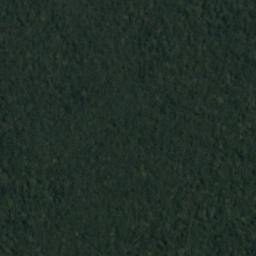

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 30ms/step
Prediction:  0
Actual:  0


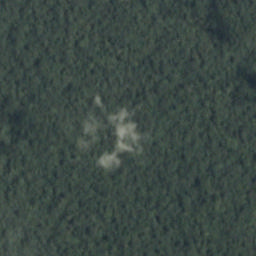

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 19ms/step
Prediction:  0
Actual:  0


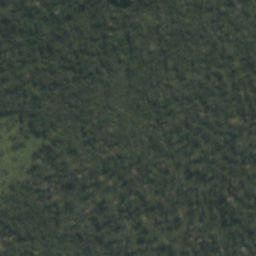

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 17ms/step
Prediction:  0
Actual:  0


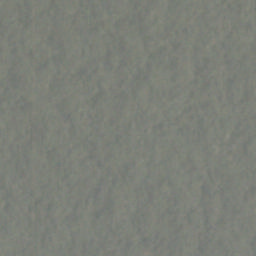

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 19ms/step
Prediction:  0
Actual:  0


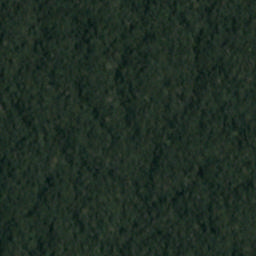

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 15ms/step
Prediction:  1
Actual:  1


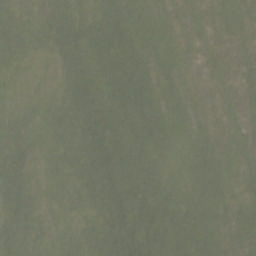

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 15ms/step
Prediction:  0
Actual:  0


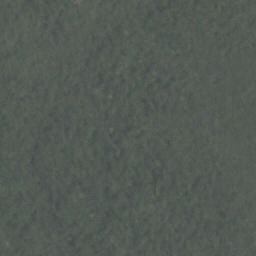

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 18ms/step
Prediction:  1
Actual:  0


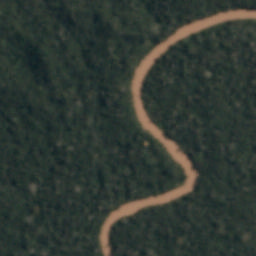

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 18ms/step
Prediction:  1
Actual:  1


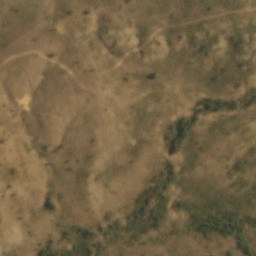

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 0s 16ms/step
Prediction:  0
Actual:  0


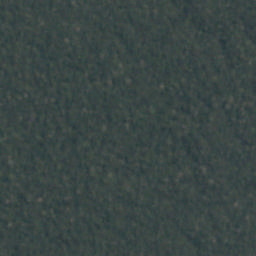


Accuracy is: 9/10


In [ ]:
# load an image off disk
correct = 0
for i in range(10):
  img_index = random.randrange(2001, len(all_img_paths))
  img = load_and_preprocess_image(all_img_paths[img_index])

  print(img.shape) # before

  im_batch = tf.expand_dims(img, axis=0) # YOUR CODE HERE, use tf.expand_dims

  print(im_batch.shape) # after

  # make predictions
  batch_pred = test_model.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 

  print("Prediction: ", round(pred[0]))
  print("Actual: ", all_bin_labels[img_index])
  display.display(display.Image(all_img_paths[img_index]))
  if round(pred[0]) == all_bin_labels[img_index]:
    correct += 1

print("")
print("Accuracy is: %d/10" % correct)

Try using a ResNet50 Model for transfer learning:

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
resNet = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
resNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# to save checkpoints of the model
checkpoint2 = ModelCheckpoint("best_resnet_model.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
for each, label in test_ds.take(1):
  print(each.numpy().max())
  print(each.numpy().min())
  print(label)

0.9978006
0.0022657507
tf.Tensor(
[1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0], shape=(64,), dtype=int64)


In [ ]:
resNet_history = resNet.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[checkpoint2])

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8453
Epoch 1: val_loss improved from 3657.45508 to 44.51215, saving model to best_resnet_model.hdf5
24/24 [==============================] - 15s 640ms/step - loss: 0.3864 - accuracy: 0.8453 - val_loss: 44.5121 - val_accuracy: 0.5900
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8760
Epoch 2: val_loss improved from 44.51215 to 2.07061, saving model to best_resnet_model.hdf5
24/24 [==============================] - 13s 550ms/step - loss: 0.3229 - accuracy: 0.8760 - val_loss: 2.0706 - val_accuracy: 0.5900
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8980
Epoch 3: val_loss improved from 2.07061 to 1.20106, saving model to best_resnet_model.hdf5
24/24 [==============================] - 13s 558ms/step - loss: 0.2674 - accuracy: 0.8980 - val_loss: 1.2011 - val_accuracy: 0.5900
Epoch 4/20
24/24 [=========================

KeyboardInterrupt: ignored

In [ ]:
my_model2 = models.Sequential()
my_model2.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model2.add(layers.MaxPooling2D())
my_model2.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model2.add(layers.MaxPooling2D())
my_model2.add(layers.Flatten())
my_model2.add(layers.Dense(128, activation="relu"))
my_model2.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
my_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = my_model2.fit(train_ds, validation_data=test_ds, epochs=15)

Epoch 1/15
24/24 [==============================] - 4s 155ms/step - loss: 1.2152 - accuracy: 0.6187 - val_loss: 0.6338 - val_accuracy: 0.6580
Epoch 2/15
24/24 [==============================] - 3s 141ms/step - loss: 0.6244 - accuracy: 0.6780 - val_loss: 0.5911 - val_accuracy: 0.7240
Epoch 3/15
24/24 [==============================] - 3s 133ms/step - loss: 0.5843 - accuracy: 0.6960 - val_loss: 0.5678 - val_accuracy: 0.7180
Epoch 4/15
24/24 [==============================] - 3s 134ms/step - loss: 0.5763 - accuracy: 0.7020 - val_loss: 0.5784 - val_accuracy: 0.6940
Epoch 5/15
24/24 [==============================] - 3s 135ms/step - loss: 0.5735 - accuracy: 0.7013 - val_loss: 0.5765 - val_accuracy: 0.7340
Epoch 6/15
24/24 [==============================] - 3s 134ms/step - loss: 0.5868 - accuracy: 0.6913 - val_loss: 0.5674 - val_accuracy: 0.7060
Epoch 7/15
24/24 [==============================] - 3s 134ms/step - loss: 0.5679 - accuracy: 0.7093 - val_loss: 0.5573 - val_accuracy: 0.7280
Epoch 

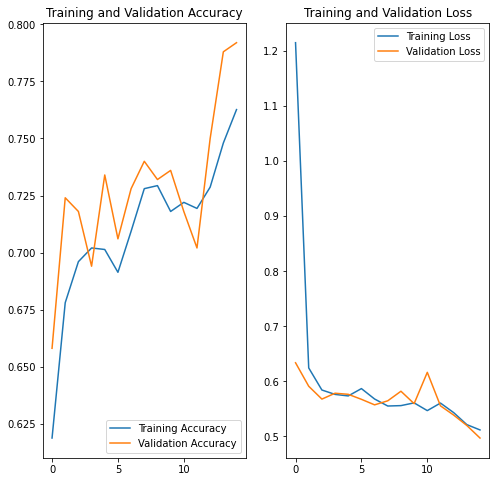

In [ ]:
# plot the training and validation loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Include Stratified Splitting:

In [ ]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(small_img_paths, 
                                                                      small_bin_labels,
                                                                      stratify=small_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [ ]:
my_model3 = models.Sequential()
my_model3.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model3.add(layers.MaxPooling2D())
my_model3.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model3.add(layers.MaxPooling2D())
my_model3.add(layers.Flatten())
my_model3.add(layers.Dense(128, activation="relu"))
my_model3.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
my_model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint3 = ModelCheckpoint("best_stratified_model.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
history3 = my_model3.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=[checkpoint3])

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.6433
Epoch 1: val_loss improved from inf to 0.59038, saving model to best_stratified_model.hdf5
24/24 [==============================] - 5s 205ms/step - loss: 0.9457 - accuracy: 0.6433 - val_loss: 0.5904 - val_accuracy: 0.7260
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.7027
Epoch 2: val_loss did not improve from 0.59038
24/24 [==============================] - 3s 132ms/step - loss: 0.6094 - accuracy: 0.7027 - val_loss: 0.6237 - val_accuracy: 0.6580
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.6953
Epoch 3: val_loss did not improve from 0.59038
24/24 [==============================] - 3s 133ms/step - loss: 0.5998 - accuracy: 0.6953 - val_loss: 0.6273 - val_accuracy: 0.6720
Epoch 4/15
24/24 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7200
Epoch 4: val_loss improved from 0.59038 to 0.5

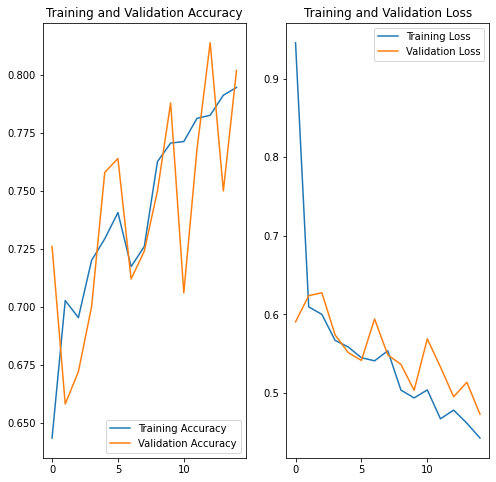

In [ ]:
# plot the training and validation loss
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()